In [5]:
import numpy as np
from calibration import CalibrationSystem, SparseModel
import gpflow
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from calibration.errormetrics import MAE, MSE, NMSE, NLPD, compute_test_data
from calibration.synthetic import generate_synthetic_dataset, getstaticsensortranform, getmobilesensortranform

In [6]:
Nstatic = 10
Nmobile = 4
Ttotal = 24*180
Nrefs = 4
Nvisitsperdayref = 0.5
Nvisitsperday = 2.5
staticsensornoise = 10
mobilesensornoise = 10
Nsamps = 1
refsensor,X,Y,trueY,statics,mobilecentres = generate_synthetic_dataset(Nstatic, Nmobile, Ttotal, Nrefs, Nvisitsperdayref, Nvisitsperday, staticsensornoise, mobilesensornoise, Nsamps)

(-0.018871327983104084,
 1.0213860254656477,
 0.01032199701019662,
 1.0249516116179571)

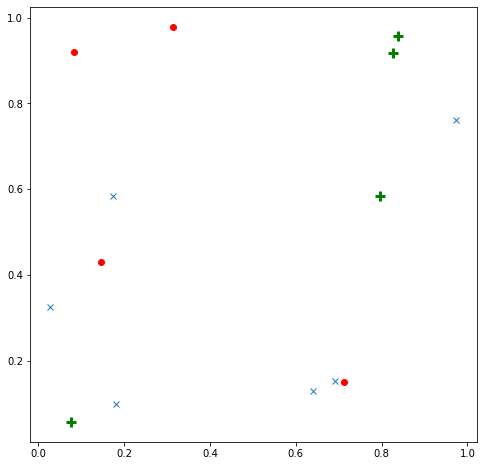

In [7]:
plt.figure(figsize=[8,8])
plt.plot(statics[:Nrefs,0],statics[:Nrefs,1],'+g',markersize=10,mew=3)
plt.plot(statics[Nrefs:,0],statics[Nrefs:,1],'x')
plt.plot(mobilecentres[:,0],mobilecentres[:,1],'ro')
plt.axis('equal')

# Applying our Method

A hacky experiment to encourage reference data to be used more...
otherwise most minibatches won't include any reference signal?
is this really dubious...?

In [8]:
refencounters = np.any(np.isin(X[:,1:],np.where(refsensor)[0]),1)
augmentedX = np.r_[X,np.repeat(X[refencounters,:],10,0)]
augmentedY = np.r_[Y,np.repeat(Y[refencounters,:],10,0)]

In [9]:
Z = np.linspace(-200,Ttotal+200,60)[:,None] ##60

In [10]:
def transform_fn(samps,Y,sideY):
    return Y*tf.exp(samps[:,:,0:1])
kernelindices = [[0]*Nstatic+[1]*Nmobile]

## Hyperparameter Search

In [11]:
for staticls in np.logspace(np.log(24*5),np.log(24*500),20,base=np.e):
    for mobilels in np.logspace(np.log(24*5),np.log(24*500),20,base=np.e):
        for likelihoodstd in np.logspace(np.log(1),np.log(50),5,base=np.e):
            kstatic = gpflow.kernels.RBF(5.0,staticls) + gpflow.kernels.Bias(1.5)
            kmobile = gpflow.kernels.RBF(5.0,mobilels) + gpflow.kernels.Bias(1.5)
            cs = CalibrationSystem(augmentedX, augmentedY, Z, refsensor, 1, transform_fn, [kstatic,kmobile], kernelindices,lr=0.01,likelihoodstd=likelihoodstd,minibatchsize=50)
            import time
            before = time.time()
            print("Starting Run")
            elbo_record = cs.run(400,samples=200) ##3000 iterations, 300 samples
            print(time.time()-before)

            testX, testY, testtrueY = compute_test_data(X,Y,trueY,refsensor)

            testsm = SparseModel(testX,cs.Z,C,cs.k)
            qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
            #qf_mu=qf_mu*0
            predY = transform_fn(qf_mu[None,:,:],testY[:,0:1],None).numpy()[:,:,0].T
            #predY[predY>100]=100
            nlpd = NLPD(np.log(testtrueY),np.log(testY[:,0:1])+qf_mu,np.sqrt(np.diag(qf_cov))[:,None])
            nmse = NMSE(testtrueY,predY)
            mse = MSE(testtrueY,predY)
            mae = MAE(testtrueY,predY)
            print("staticls=%5.2f, mobilels=%5.2f likelihoodstd=%5.2f: nlpd=%5.2f nmse=%5.2f mse=%5.2f mae=%5.2f" % (staticls,mobilels,likelihoodstd,nlpd,nmse,mse,mae))

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Starting Run
Starting Run
....................6.068985462188721


NameError: name 'C' is not defined

In [12]:
#this seems to work ok.
kstatic = gpflow.kernels.RBF(5.0,24*40) + gpflow.kernels.Bias(1.5)
kmobile = gpflow.kernels.RBF(5.0,24*12) + gpflow.kernels.Bias(1.5)
cs = CalibrationSystem(augmentedX, augmentedY, Z, refsensor, 1, transform_fn, [kstatic,kmobile], kernelindices,lr=0.01,likelihoodstd=10.0,minibatchsize=50)
import time
before = time.time()
print("Starting Run")
elbo_record = cs.run(2000,samples=200) ##3000 iterations, 300 samples
print(time.time()-before)

Starting Run
Starting Run
......1.6479582786560059


## Compute Chosen Config

In [13]:
#kstatic = gpflow.kernels.RBF(5.0,24*40) + gpflow.kernels.Bias(1.5)
#kmobile = gpflow.kernels.RBF(5.0,24*12) + gpflow.kernels.Bias(1.5)
#cs = CalibrationSystem(augmentedX, augmentedY, Z, refsensor, 1, transform_fn, [kstatic,kmobile], kernelindices,lr=0.02,likelihoodstd=25,minibatchsize=100)
#import time
#before = time.time()
#print("Starting Run")
#elbo_record = cs.run(50,samples=300) ##3000 iterations, 300 samples
#print(time.time()-before)

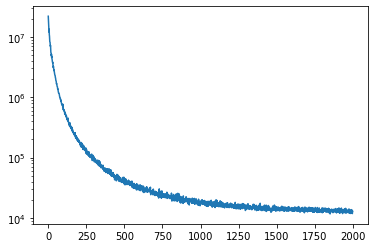

In [9]:
plt.plot(elbo_record)
plt.yscale('log')

In [21]:
testX, testY, testtrueY = compute_test_data(X,Y,trueY,refsensor)

In [31]:
trueY

array([71.95656792, 45.47684881, 22.41381502, ..., 75.76865861,
       66.46628165, 62.88727313])

# Simple Effort

For comparison we run a simple version to try to generate calibration predictions too.

In [16]:
from calibration.simple import compute_simple_calibration, compute_simple_predictions
delta = 24*100
G,allsp,allcals,allcallists,allpopts,allpcovs,allpoptslists = compute_simple_calibration(X,Y,delta,refsensor)
preds,res2,res = compute_simple_predictions(testX,testY,testtrueY,allcals,delta)

/home/mike/Documents/Research/calibration/calibration/simple.py:58: RuntimeWarning: invalid value encountered in log
  allpopts[s] = np.sum(np.log([G.get_edge_data(u,v)['popt'] for u,v in zip(allsp[s][:-1],allsp[s][1:])]),0)


In [32]:
print("Corrected:")
nmse = NMSE(testtrueY[:,0],preds[:,0])
mse = MSE(testtrueY[:,0],preds[:,0])
mae = MAE(testtrueY[:,0],preds[:,0])
print("nmse=%5.5f mse=%5.2f mae=%5.2f" % (nmse,mse,mae))

Corrected:
nmse=0.12890 mse=435.00 mae=15.50


In [28]:
testsm = SparseModel(testX,cs.Z,1,cs.k)
qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
#qf_mu=qf_mu*0
predY = transform_fn(qf_mu[None,:,:],testY[:,0:1],None).numpy()[:,:,0].T

In [29]:
nlpd = NLPD(np.log(testtrueY[:,0]),np.log(testY[:,0:1])+qf_mu[:,0],np.sqrt(np.diag(qf_cov)))
keep = ~np.isnan(testtrueY)
nmse = NMSE(testtrueY[:,0],predY[:,0])
mse = MSE(testtrueY[:,0],predY[:,0])
mae = MAE(testtrueY[:,0],predY[:,0])
print("nlpd=%5.2f nmse=%5.5f mse=%5.2f mae=%5.2f" % (nlpd,nmse,mse,mae))

nlpd=118.98 nmse=0.05783 mse=198.00 mae=10.77


In [ ]:
print("Corrected:")
nmse = NMSE(testtrueY[:,0],pred[:,0])
mse = MSE(testtrueY[:,0],preds[:,0])
mae = MAE(testtrueY[:,0],preds[:,0])
print("nmse=%5.5f mse=%5.2f mae=%5.2f" % (nmse,mse,mae))

In [10]:
from calibration.simple import compute_simple_solution,plotbars,compute_simple_predictions
from calibration.errormetrics import compute_test_data

delta = 24*10
allscales = compute_simple_solution(X,Y,refsensor,delta)

testX, testY, testtrueY = compute_test_data(X,Y,trueY,refsensor)

ImportError: cannot import name 'compute_simple_solution' from 'calibration.simple' (/home/mike/Documents/Research/calibration/calibration/simple.py)

# Plot

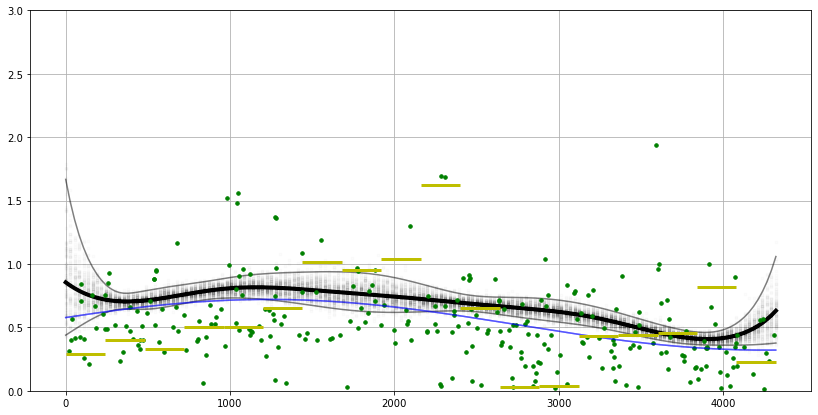

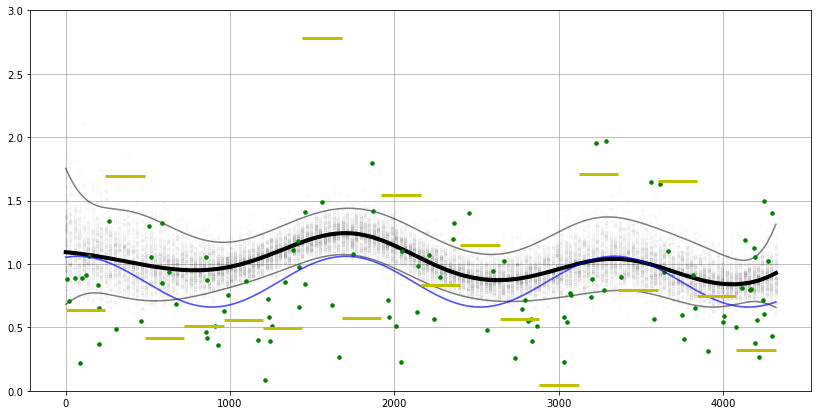

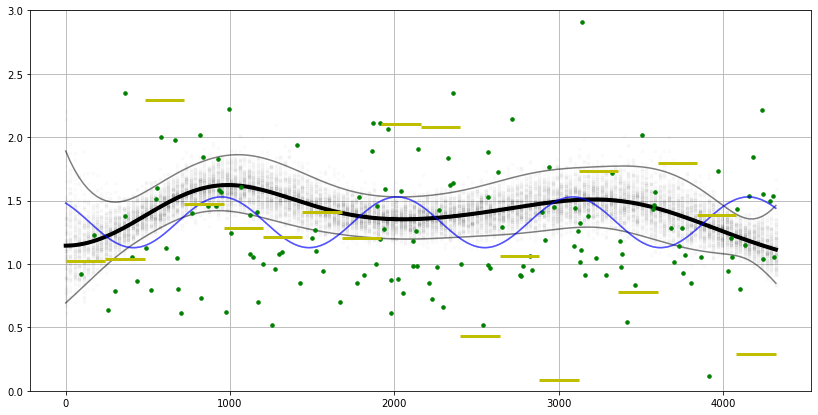

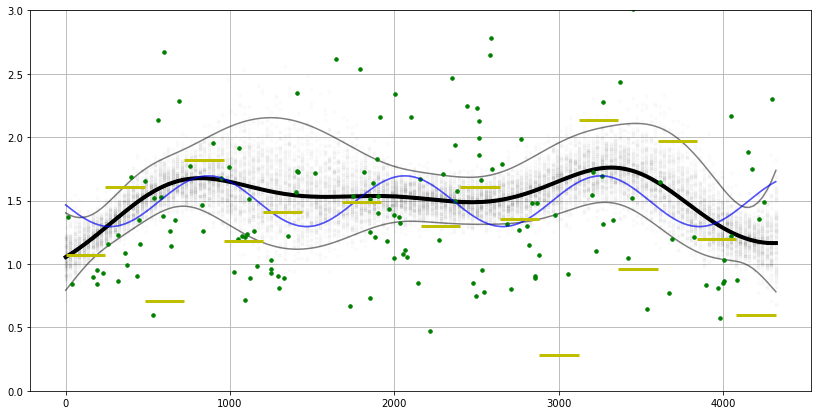

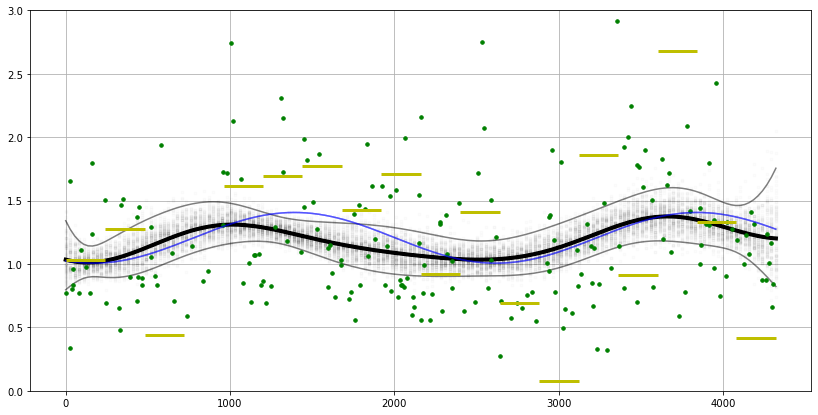

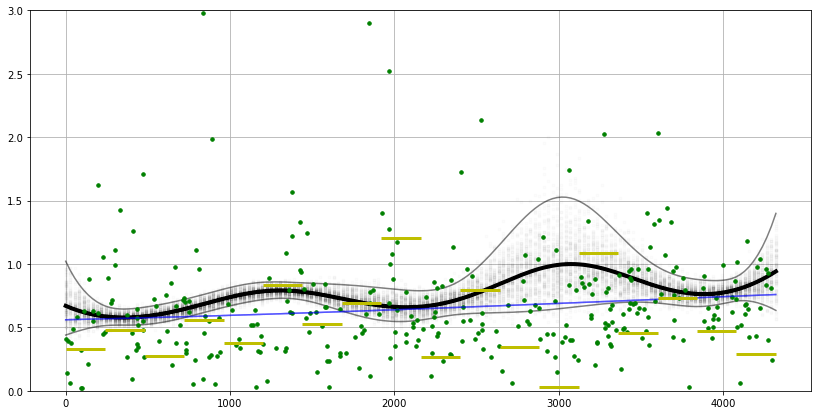

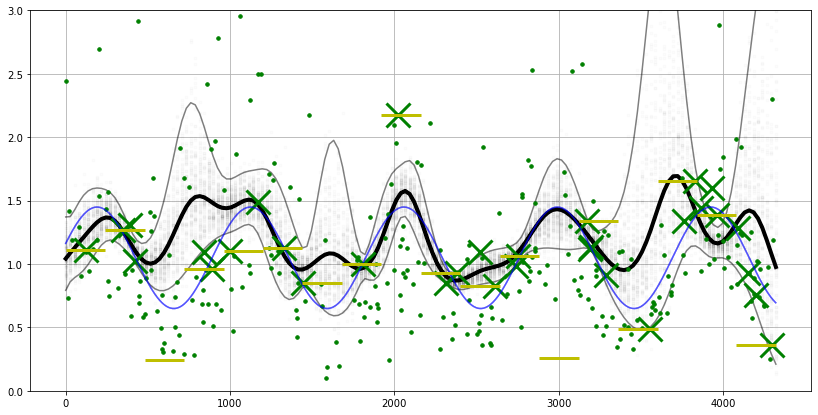

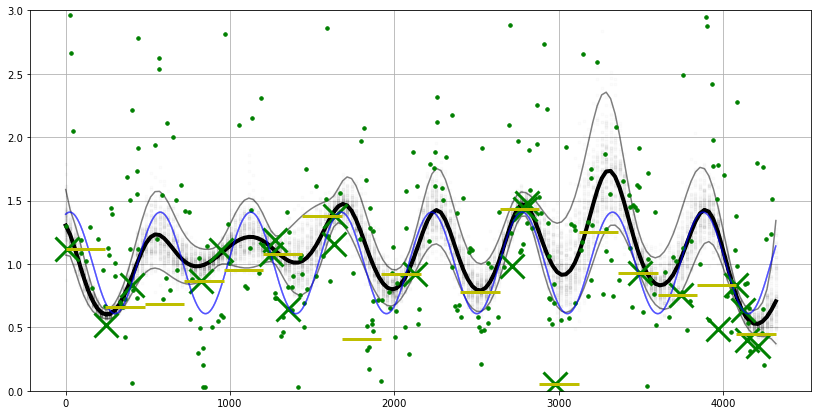

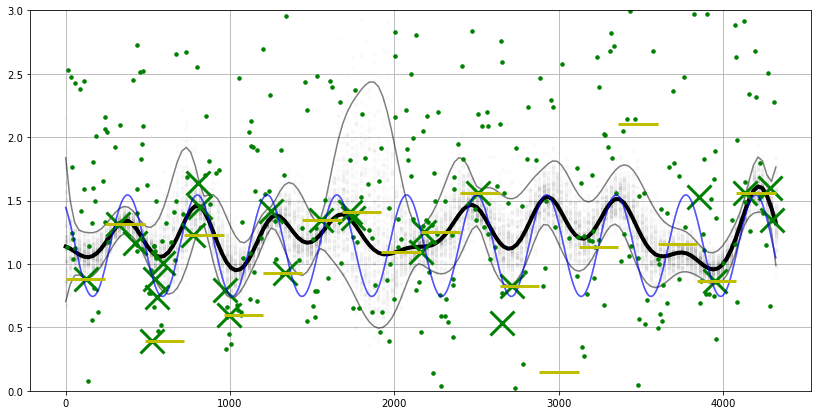

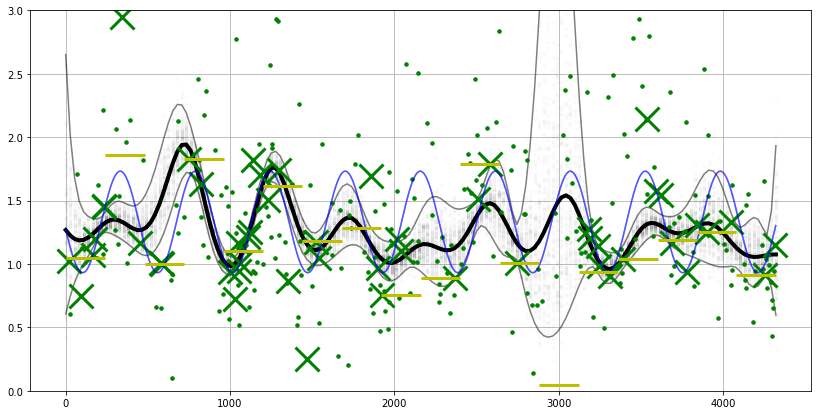

In [21]:
C = 1
for si,refs in enumerate(refsensor):
    if refs: continue
    x = np.linspace(0,Ttotal,160)
    testX = np.zeros([0,3])
    for ci in range(C):
        tempX = np.c_[x,np.ones_like(x)*si,np.full_like(x,ci)]
        testX = np.r_[testX,tempX]#.astype(int)
    testsm = SparseModel(testX,cs.Z,C,cs.k)
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    if cs.mulike is not None:
        qf_mulike,qf_covlike = testsm.get_qf(cs.mulike,cs.scalelike)
        sampslike = testsm.get_samples_one_sensor(cs.mulike,cs.scalelike)
    samps = testsm.get_samples_one_sensor(cs.mu,cs.scale)
    
    plt.figure(figsize=[14,7])
    plt.plot(x,1/tf.exp(qf_mu[:,0]),'k-',lw=4)
    plt.plot(x,1/np.exp(samps[:,:,0].numpy().T),'k.',alpha=0.01);
    
    plt.plot(x,1/tf.exp((qf_mu[:,0]+2*np.sqrt(np.diag(qf_cov)[:]))),'k-',alpha=0.5)
    plt.plot(x,1/tf.exp((qf_mu[:,0]-2*np.sqrt(np.diag(qf_cov)[:]))),'k-',alpha=0.5)

    senseX = (X[:,1]==si) & (X[:,2]<Nrefs)
    plt.plot(X[senseX,0],Y[senseX,0]/Y[senseX,1],'xg',markersize=24,mew=3)
    
    
        
    senseX = (X[:,2]==si) & (X[:,1]<Nrefs)
    plt.plot(X[senseX,0],Y[senseX,1]/Y[senseX,0],'xg',markersize=24,mew=3)
    senseX = (X[:,1]==si)
    plt.plot(X[senseX,0],Y[senseX,0]/Y[senseX,1],'.g',markersize=7)
    senseX = (X[:,2]==si)
    plt.plot(X[senseX,0],Y[senseX,1]/Y[senseX,0],'.g',markersize=7)    
    plotbars(np.arange(0,np.max(X[:,0]),delta),delta,np.exp(allscales[:,si]),'y')
    plt.ylim([0,3])
    #plt.yscale('log')
    plt.grid()
    if si<Nstatic:
        for samp in range(10):
            plt.plot([(getstaticsensortranform(t,100.0,Nrefs,si,noisescale=0)/100) for t in np.arange(Ttotal)],'b-',alpha=0.1)
    else:
        for samp in range(10):
            plt.plot([(getmobilesensortranform(t,100.0,si-Nstatic,noisescale=0)/100) for t in np.arange(Ttotal)],'b-',alpha=0.1)

In [4]:
testX, testY, testtrueY = compute_test_data(X,Y,trueY,refsensor)
    
testsm = SparseModel(testX,cs.Z,C,cs.k)
qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
#qf_mu=qf_mu*0
predY = transform_fn(qf_mu[None,:,:],testY[:,0:1],None).numpy()[:,:,0].T
#predY[predY>100]=100

nlpd = NLPD(np.log(testtrueY),np.log(testY[:,0:1])+qf_mu,np.sqrt(np.diag(qf_cov))[:,None])
nmse = NMSE(testtrueY,predY)
mse = MSE(testtrueY,predY)
mae = MAE(testtrueY,predY)
print("nlpd=%5.2f nmse=%5.2f mse=%5.2f mae=%5.2f" % (nlpd,nmse,mse,mae))

NameError: name 'cs' is not defined

In [16]:
simple_predY = compute_simple_predictions(testX,testY,allscales,delta)
simple_predY[simple_predY>100]=100
#simple_predY = 0*simple_predY + np.mean(testY)
nmse = NMSE(testtrueY,simple_predY)
mse = MSE(testtrueY,simple_predY)
mae = MAE(testtrueY,simple_predY)
print("nlpd=N/A   nmse=%5.2f mse=%5.2f mae=%5.2f" % (nmse,mse,mae))

nlpd=N/A   nmse= 0.16 mse=567.07 mae=20.43


(0.0, 200.0)

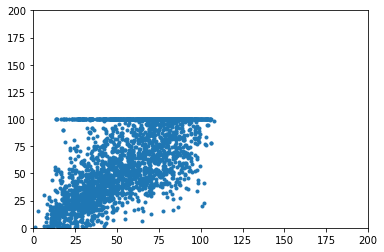

In [14]:
plt.plot(testtrueY,simple_predY,'.')
plt.ylim([0,200])
plt.xlim([0,200])


(0.0, 200.0)

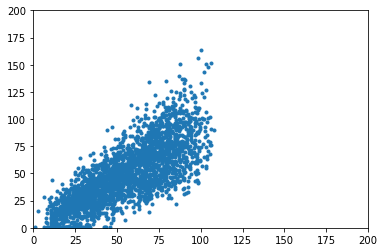

In [15]:
plt.plot(testtrueY,predY,'.')
plt.ylim([0,200])
plt.xlim([0,200])